In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import spacy
import textblob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-review/K8 Reviews v0.2.csv


In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
data = pd.read_csv("../input/amazon-review/K8 Reviews v0.2.csv")
data.sample(10)

,sentiment,review
8469,0,Nice
14514,1,This phone works good for first 4 months and t...
3416,0,"Bad product not working properly, heating issu..."
12819,0,It is a pathetic phone.
12066,1,Good product
12056,0,Camera is not up to the point. Heats up while ...
7872,1,This phone is superb... Only issue here is cha...
8386,1,It's awesome
3404,1,Very nyc phone
401,0,Nice phone at this price range.....deca core p...


In [5]:
data.shape

(14675, 2)

In [6]:
data['sentiment'].value_counts()

0    7712
1    6963
Name: sentiment, dtype: int64

The dataset is fairly balanced

#### What's the average length of review for negative sentiment vs positive sentiment?

In [7]:
data['length_of_review'] = data['review'].apply(len)

In [8]:
data.head()

,sentiment,review,length_of_review
0,1,Good but need updates and improvements,38
1,0,"Worst mobile i have bought ever, Battery is dr...",475
2,1,when I will get my 10% cash back.... its alrea...,61
3,1,Good,4
4,0,The worst phone everThey have changed the last...,156


In [9]:
data.groupby(['sentiment']).mean()['length_of_review']

sentiment
0    154.957339
1     66.791182
Name: length_of_review, dtype: float64

It seems like people tend to write more elaborate reviews when they are unhappy with the product. 

In [10]:
data.isna().sum()

sentiment           0
review              0
length_of_review    0
dtype: int64

### POS TAGGING, STOPWORD REMOVAL, NORMALIZE CASINGS

In [11]:
nlp.Defaults.stop_words |= {"n't", "phone", "mobile", "lenovo","note", "k8",}

In [12]:
data['reviews_cleaned_sp'] = data['review'].apply(lambda x: ' '.join([(token.text).lower() for token in nlp(x.lower()) if not token.is_stop if token.pos_ in ["NOUN", "PROPN"] if len(token.text)>2]))

In [13]:
data['reviews_cleaned_sp'].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z ]', value=r'')
data[['review','reviews_cleaned_sp']]

,review,reviews_cleaned_sp
0,Good but need updates and improvements,updates improvements
1,"Worst mobile i have bought ever, Battery is dr...",battery hell backup hours internet uses idle d...
2,when I will get my 10% cash back.... its alrea...,cash january
3,Good,
4,The worst phone everThey have changed the last...,problem amazon amazon
...,...,...
14670,"I really like the phone, Everything is working...",
14671,The Lenovo K8 Note is awesome. It takes best p...,pictures camera body bit hand cover features a...
14672,Awesome Gaget.. @ this price,gaget price
14673,This phone is nice processing will be successf...,processing camera mod


#### Visualizing words

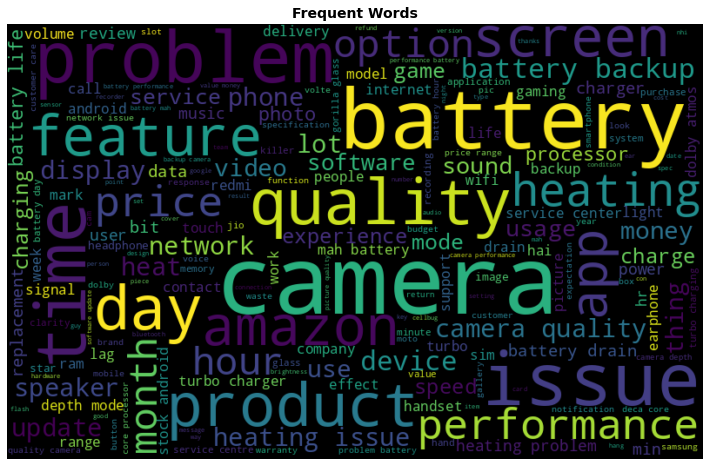

<Figure size 432x288 with 0 Axes>

In [14]:
from wordcloud import WordCloud
all_words = ''.join([word for word in data['reviews_cleaned_sp'][::]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent Words", weight='bold', fontsize=14)
plt.show()
plt.savefig("Wordcloud.png")

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                   max_df=0.5,
                                   min_df=0.01,
                                  max_features=50000)
vectorized_corpus = tfidf_vectorizer.fit_transform(data['reviews_cleaned_sp'])

In [17]:
vectorized_corpus.shape

(14675, 72)

In [18]:
corpus_array = vectorized_corpus.toarray()

### Top words in positive and negative sentiment

In [19]:
sentiment = data['sentiment']

In [20]:
positive = corpus_array[np.where(sentiment==1)]
negative = corpus_array[np.where(sentiment==0)]

In [21]:
feature_names = tfidf_vectorizer.get_feature_names()

In [22]:
type(positive.sum(0))

numpy.ndarray

In [23]:
def get_top_features(arr, feature_names, n_top):
    tple  = zip(feature_names,arr.sum(0).tolist())
    sortedtpl = sorted(tple,key=lambda x: x[1], reverse=True)[:n_top]
    feature_list = [x[0] for x in sortedtpl]
    value_list = [x[1] for x in sortedtpl]
    return (feature_list,value_list)

In [24]:
top_pos = get_top_features(positive,feature_names,15)
top_neg = get_top_features(negative,feature_names,15)

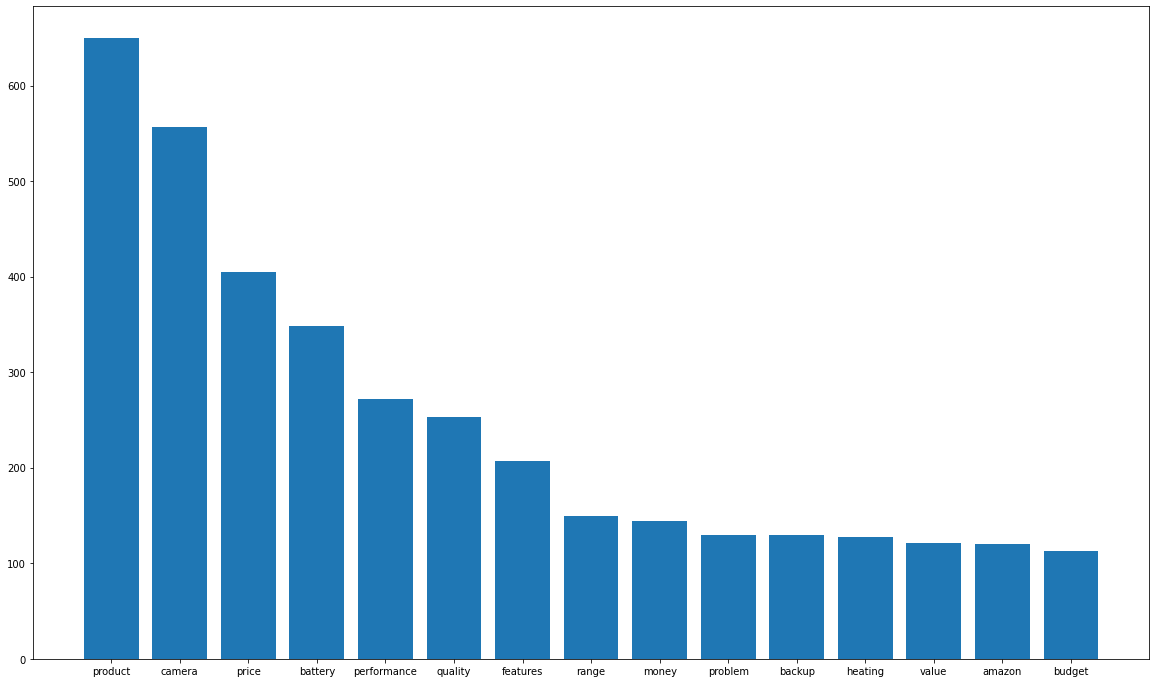

In [25]:
plt.rcParams['figure.figsize'] = (20,12)
plt.bar(top_pos[0],top_pos[1])
plt.savefig("positive.png")

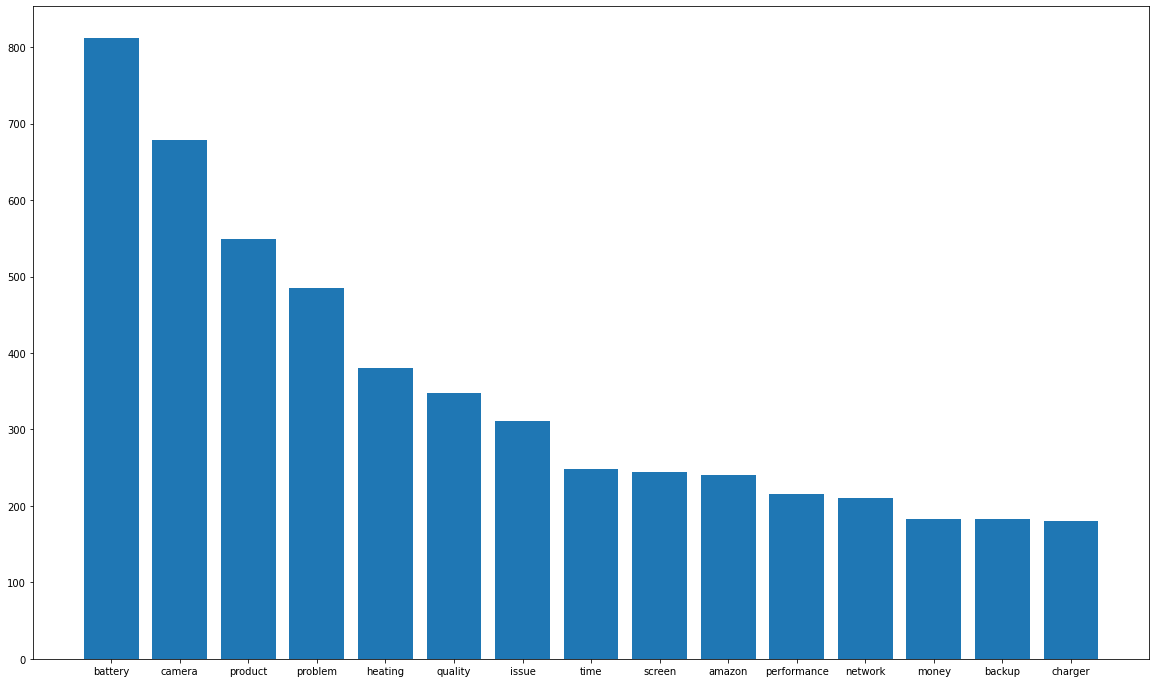

In [26]:
plt.bar(top_neg[0],top_neg[1])
plt.savefig("negative.png")

From this chart we can infer that battery, camera and heating are being talked negatively. So the phone probably has poor battery life, camera quality and overheating issues. 

## Building LDA model using Gensim

In [27]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import ldamodel

In [28]:
from nltk.tokenize import word_tokenize
data['reviews_token'] = [word_tokenize(sent) for sent in data.reviews_cleaned_sp]

In [29]:
data

,sentiment,review,length_of_review,reviews_cleaned_sp,reviews_token
0,1,Good but need updates and improvements,38,updates improvements,"[updates, improvements]"
1,0,"Worst mobile i have bought ever, Battery is dr...",475,battery hell backup hours internet uses idle d...,"[battery, hell, backup, hours, internet, uses,..."
2,1,when I will get my 10% cash back.... its alrea...,61,cash january,"[cash, january]"
3,1,Good,4,,[]
4,0,The worst phone everThey have changed the last...,156,problem amazon amazon,"[problem, amazon, amazon]"
...,...,...,...,...,...
14670,1,"I really like the phone, Everything is working...",78,,[]
14671,1,The Lenovo K8 Note is awesome. It takes best p...,246,pictures camera body bit hand cover features a...,"[pictures, camera, body, bit, hand, cover, fea..."
14672,1,Awesome Gaget.. @ this price,28,gaget price,"[gaget, price]"
14673,1,This phone is nice processing will be successf...,99,processing camera mod,"[processing, camera, mod]"


In [30]:
id2word = corpora.Dictionary(data.reviews_token)
texts = data.reviews_token
corpus = [id2word.doc2bow(text) for text in texts]

#### Create model with 12 topics

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=20,
                                           passes=15,
                                           per_word_topics=True)

#### Show top terms for each topic

In [32]:
for index, topic in lda_model.show_topics(num_topics = 12, formatted=False, num_words= 15):
    print('Topic #{}: {}'.format(index,'|'.join(w[0] for w in topic)))

Topic #0: camera|performance|mode|processor|android|update|depth|software|stock|clarity|user|system|bit|gaming|core
Topic #1: video|mark|apps|music|light|redmi|photos|notification|ram|google|videos|image|moto|speakers|message
Topic #2: camera|quality|speaker|sound|touch|picture|display|photo|superb|time|class|rest|images|color|stars
Topic #3: battery|backup|charger|hours|turbo|time|life|day|charging|usage|performance|charge|mah|hrs|use
Topic #4: amazon|product|service|days|time|delivery|handset|replacement|customer|experience|return|center|thanks|purchase|piece
Topic #5: money|waste|value|glass|volte|gorilla|cover|item|hang|k|pictures|lte|look|refund|order
Topic #6: screen|bluetooth|data|box|times|wifi|cast|calls|connection|headset|usb|ear|cable|solution|bed
Topic #7: dolby|budget|display|heat|killer|sound|phones|atmos|volume|music|buy|thing|button|samsung|cell
Topic #8: features|camera|feature|app|screen|option|speed|card|sensor|memory|recording|voice|lot|flash|good
Topic #9: problem|

In [33]:
type(texts)

pandas.core.series.Series

In [34]:
reviews = data['review']

### View the topic which is most dominant in each document, get topic probability and attach topic keywords to dataframe

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts, original_text = reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = original_text
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts, original_text=reviews)

In [37]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,review
0,10.0,0.6944,"hai, smartphone, nhi, device, bill, bhi, hota,...",Good but need updates and improvements
1,3.0,0.5345,"battery, backup, charger, hours, turbo, time, ...","Worst mobile i have bought ever, Battery is dr..."
2,11.0,0.3611,"product, price, range, features, month, earpho...",when I will get my 10% cash back.... its alrea...
3,0.0,0.0833,"camera, performance, mode, processor, android,...",Good
4,4.0,0.5208,"amazon, product, service, days, time, delivery...",The worst phone everThey have changed the last...
...,...,...,...,...
14670,0.0,0.0833,"camera, performance, mode, processor, android,...","I really like the phone, Everything is working..."
14671,0.0,0.4858,"camera, performance, mode, processor, android,...",The Lenovo K8 Note is awesome. It takes best p...
14672,11.0,0.5525,"product, price, range, features, month, earpho...",Awesome Gaget.. @ this price
14673,9.0,0.3786,"problem, heating, issue, network, issues, jio,...",This phone is nice processing will be successf...


In [38]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6944,"hai, smartphone, nhi, device, bill, bhi, hota,...",Good but need updates and improvements
1,1,3.0,0.5345,"battery, backup, charger, hours, turbo, time, ...","Worst mobile i have bought ever, Battery is dr..."
2,2,11.0,0.3611,"product, price, range, features, month, earpho...",when I will get my 10% cash back.... its alrea...
3,3,0.0,0.0833,"camera, performance, mode, processor, android,...",Good
4,4,4.0,0.5208,"amazon, product, service, days, time, delivery...",The worst phone everThey have changed the last...
5,5,5.0,0.5428,"money, waste, value, glass, volte, gorilla, co...",Only I'm telling don't buyI'm totally disappoi...
6,6,5.0,0.5428,"money, waste, value, glass, volte, gorilla, co...","Phone is awesome. But while charging, it heats..."
7,7,3.0,0.3611,"battery, backup, charger, hours, turbo, time, ...",The battery level has worn down
8,8,4.0,0.8852,"amazon, product, service, days, time, delivery...",It's over hitting problems...and phone hanging...
9,9,8.0,0.4167,"features, camera, feature, app, screen, option...",A lot of glitches dont buy this thing better g...


In [39]:
pd.set_option('display.max_colwidth', None) 

### View the three most relevant documents for each topic

In [40]:
def sort_df_by_topic_contrib(df_dominant_topic):
    df_rep_doc = df_dominant_topic.sort_values(['Topic_Perc_Contrib'], ascending=False).groupby(['Dominant_Topic']).head(3)
    df_rep_doc = df_rep_doc.sort_values(['Dominant_Topic'])
    return df_rep_doc

In [41]:
sort_df_by_topic_contrib(df_dominant_topic)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5181,5181,0.0,0.8723,"camera, performance, mode, processor, android, update, depth, software, stock, clarity",Full paisa wasool lookFull paisa wasool cameraFull paisa wasool processorFull paisa wasool display with gorilla glassFull paisa wasool price.Over allFull paisa wasool.
4417,4417,0.0,0.9084,"camera, performance, mode, processor, android, update, depth, software, stock, clarity",Excellent Performance Mediatek Hello X23 Deca Core SoC Is Rocking.Only The Down Point Is The RAM Management.
1812,1812,0.0,0.8849,"camera, performance, mode, processor, android, update, depth, software, stock, clarity",Pros:Good BatteryStock AndroidVery SmoothCons:Bad Dual Camera (Probably a fix with software update)Sometimes Overheats
275,275,1.0,0.8468,"video, mark, apps, music, light, redmi, photos, notification, ram, google",I bought this phone for my friendHe is pretty happy with the phoneAll the specs meet his daily basic requirementsButA highly skinned os makes it little fullOtherwise a great tech
1232,1232,1.0,0.9166,"video, mark, apps, music, light, redmi, photos, notification, ram, google","What are all the Pro's and Con's of this device, watch the Full REVIEW Vs Redmi Note 4 on my utube channel, DennisCNLew .. also watch the Durability BEND Test and Splash Test!!!"
4739,4739,1.0,0.8690,"video, mark, apps, music, light, redmi, photos, notification, ram, google",Amazing the inbuilt is so nice and made by Motorola. This phone is combination of Moto and Lenovo. Better than any phones of Mi because their phones are not trustable.
1852,1852,2.0,0.8468,"camera, quality, speaker, sound, touch, picture, display, photo, superb, time",When I put the hadephone but don't show the sine of hadephone.....but I hear clearly on hadephone.... please tell me the process ..
461,461,2.0,0.8690,"camera, quality, speaker, sound, touch, picture, display, photo, superb, time","Awesome phone...no lag, camera is average but with lil effort you can pull fine quality images."
2914,2914,2.0,0.8691,"camera, quality, speaker, sound, touch, picture, display, photo, superb, time",Camera not goodgood split performanceBattery backup goodVery best soundsRear camera is not good as copmare to dual camera.
14218,14218,3.0,0.9238,"battery, backup, charger, hours, turbo, time, life, day, charging, usage","Worst device.. device getting so heat while charging also not getting charge fast.... even very difficult to call on this device as that heat hurt Ears..Battery Drain quickly, not working for a full one day even if you are not using Net."


### Assign names to each topic for business usecase

In [42]:
topicdict = {}
for index, topic in lda_model.show_topics(num_topics = 12, formatted=False, num_words= 15):
    topicdict[index] = ', '.join(w[0] for w in topic)
final_topics = pd.DataFrame(topicdict.items())
topic_dict = {0:"Software", 
              1:"None", 
              2:"Camera and Sound", 
              3:"Battery and Overheating", 
              4:"Amazon Service", 
              5:"Value for money", 
              6:"Packaging and Screen cast", 
              7:"Sound sytem", 
              8:"Low Memory/RAM and missing features", 
              9:"Network issue and heating", 
              10:"None", 
              11:"Price"}
final_topics.columns = ["Topic Num", "Keywords"]
final_topics['topic_names'] = pd.Series(topic_dict).sort_index()
final_topics

,Topic Num,Keywords,topic_names
0,0,"camera, performance, mode, processor, android, update, depth, software, stock, clarity, user, system, bit, gaming, core",Software
1,1,"video, mark, apps, music, light, redmi, photos, notification, ram, google, videos, image, moto, speakers, message",None
2,2,"camera, quality, speaker, sound, touch, picture, display, photo, superb, time, class, rest, images, color, stars",Camera and Sound
3,3,"battery, backup, charger, hours, turbo, time, life, day, charging, usage, performance, charge, mah, hrs, use",Battery and Overheating
4,4,"amazon, product, service, days, time, delivery, handset, replacement, customer, experience, return, center, thanks, purchase, piece",Amazon Service
5,5,"money, waste, value, glass, volte, gorilla, cover, item, hang, k, pictures, lte, look, refund, order",Value for money
6,6,"screen, bluetooth, data, box, times, wifi, cast, calls, connection, headset, usb, ear, cable, solution, bed",Packaging and Screen cast
7,7,"dolby, budget, display, heat, killer, sound, phones, atmos, volume, music, buy, thing, button, samsung, cell",Sound sytem
8,8,"features, camera, feature, app, screen, option, speed, card, sensor, memory, recording, voice, lot, flash, good",Low Memory/RAM and missing features
9,9,"problem, heating, issue, network, issues, jio, signal, sim, problems, work, software, internet, star, update, day",Network issue and heating


#### Which of the topics can be merged?

In the above table topic#4 and topic#6 can be merged, topic#7 and topic#2 can be merged and topic#1 and topic#10 can be merged

### Compute Coherence Score

In [43]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5256851629910054


### Find the most optimum model

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
    
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=20,
                                           passes=15,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
limit=20
start=2
step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)


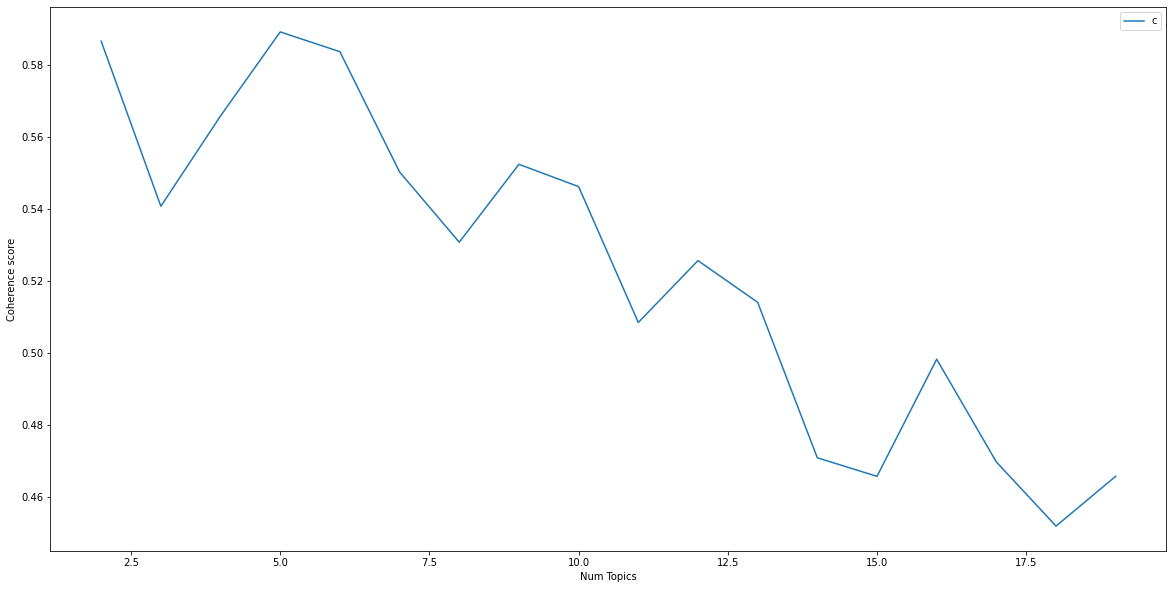

<Figure size 1440x720 with 0 Axes>

In [46]:
# Show graph
plt.rcParams['figure.figsize'] = (20,10)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig("optimum_topics.png")

In [47]:
coherence_values

[0.5867435218233518,
 0.5408105566665805,
 0.5659497729740548,
 0.5893290109066381,
 0.5838185705710087,
 0.5503611004924963,
 0.5308087500673625,
 0.5524837324377484,
 0.5462764667497249,
 0.508474163044058,
 0.5256851629910054,
 0.5140793474622767,
 0.4708130530292345,
 0.46565240568814154,
 0.49824944828449075,
 0.4696487964642688,
 0.45180645356575044,
 0.46567599593477355]

### Print topics for the best model (num_topics = 5)

In [48]:
best_model_index = coherence_values.index(max(coherence_values))
num_topics_best = best_model_index + 2
lda_model_best = model_list[best_model_index]
for index, topic in lda_model_best.show_topics(num_topics = num_topics_best, formatted=False, num_words= 15):
    print('Topic #{}: {}'.format(index,'|'.join(w[0] for w in topic)))

Topic #0: camera|performance|mode|quality|processor|android|battery|dolby|depth|music|ram|sound|display|device|stock
Topic #1: price|features|screen|range|option|app|phones|volte|sensor|feature|recording|video|gallery|smartphone|apps
Topic #2: camera|quality|network|problem|speaker|jio|sim|bluetooth|speed|picture|calls|time|handset|sound|connectivity
Topic #3: battery|heating|issue|problem|backup|time|charger|issues|hours|turbo|day|life|heat|charging|update
Topic #4: product|amazon|money|service|waste|delivery|value|hai|replacement|customer|return|time|center|box|days


### Print topics for the second best model (num_topics = 6)

In [49]:
lda_model_second_best = model_list[4]
for index, topic in lda_model_second_best.show_topics(num_topics = 6, formatted=False, num_words= 15):
    print('Topic #{}: {}'.format(index,'|'.join(w[0] for w in topic)))

Topic #0: camera|performance|mode|android|dolby|depth|display|sound|device|quality|software|stock|signal|music|apps
Topic #1: price|camera|features|screen|range|quality|feature|option|processor|app|video|touch|sensor|recording|core
Topic #2: camera|quality|problem|network|heating|issue|speaker|jio|sim|bluetooth|mark|calls|work|sound|handset
Topic #3: battery|heating|issue|backup|problem|issues|time|charger|day|hours|turbo|life|heat|performance|charging
Topic #4: product|amazon|service|delivery|days|replacement|time|customer|experience|return|center|box|screen|thanks|piece
Topic #5: money|waste|value|hai|glass|gorilla|screen|nhi|set|nahi|bill|bed|bhi|display|head


#### It can be observed that num_topics = 5 provide a better segmentation into topics than num_topics = 6

### Coherence score for best topic

In [50]:
coh_score = coherence_values[best_model_index]
print(coh_score)

0.5893290109066381


### View the 3 most relevant documents for each topic, along with topic probability, keywords and document number

In [51]:
df_topic_keywords = format_topics_sentences(ldamodel=lda_model_best, corpus=corpus, texts=texts, original_text=reviews)
# Format
df_dominant_topic_best = df_topic_keywords.reset_index()
df_dominant_topic_best.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
sort_df_by_topic_contrib(df_dominant_topic_best)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1457,1457,0.0,0.9720,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music","Pros1.stock Android2. Faster updates3. Very fast installation4. Comparatively fast and responsiveSmooth.5. Speaker on this phone is awesome6. Dolby Atmos7. Headphone output (bit above avg)8. Design looks very poor.Cons1.Depth mode is marketing gimmick,2.fixed focus front camera,3.both camera lenses are very poor quality very poor camera performance,4.OS needs lot of stabilization, below 15% battery , the phone starts behaving very weirdly!(I guess it's due to power saving mode)5. Display quality is poor ."
2793,2793,0.0,0.9550,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music","Dolby Atmos / Sound output is pathetic. I used my Sony headpones other Lenovo k series it was awesome. But on this it is like using some cheap Chinese phone. Even my Samsung on5 gives far greater output than this.I searched online, & found that people are already complaining to Lenovo about this issue but no action has been taken yet.Unfortunately I am not able to return this as there is no option available from Amazon.Dolby was the only USP in k8 which I was looking forward to & that came out to be the worst one.EXTREMELY DISAPPOINTED !"
5408,5408,0.0,0.9548,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music",this phone comes with lots of probleam and i am buy this phone only features for dual camera but i am not satisfied of this phone because secondary camera are not work in depth mode and clear photos as low light i hope the secondary camera is not any work here?My suggestion lenovo improve ur quality and features.There is nothing like what you are getting on the phone's features if you are taking dual camera for a bad phone
5274,5274,1.0,0.9269,"price, features, screen, range, option, app, phones, volte, sensor, feature",A few very common features missing which is very strange.1. You can't select any tune from your labs as a ringtone.2. It doesn't support VoLTE.3. There is no screen mirroring.4. Phone gets hot after long usage.All these features nowadays are available in lower phones but somehow Lenovo has missed to provide. Any clue why?
11513,11513,1.0,0.9268,"price, features, screen, range, option, app, phones, volte, sensor, feature",Some of the basic software features are missing like1. The option for scheduled power ON/OFF is not there.2. The option for customised ringtone is not there.3. The option for hotspot metering like in lenovo k3 note is not there.
1232,1232,1.0,0.9262,"price, features, screen, range, option, app, phones, volte, sensor, feature","What are all the Pro's and Con's of this device, watch the Full REVIEW Vs Redmi Note 4 on my utube channel, DennisCNLew .. also watch the Durability BEND Test and Splash Test!!!"
7783,7783,2.0,0.9424,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",(1) Call k Doran slide baar niche aajata h kaan k touch hotehi .(2) light Sencer is not work properly.(3)beatry is not longer time work.
3124,3124,2.0,0.9270,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",back camera bekarga undi lanjodukuam camera ra edi nee.......back camera mari worast ga undi
1125,1125,2.0,0.9267,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",I face some problemsSensor problemBattery drain too fastApp hangedScreen touch show mark after click in callin Manageri think u sent me a defective pice
11837,11837,3.0,0.9595,"battery, heating, issue, problem, backup, time, charger, issues, hours, turbo",Hi guys I have received it yesterday only. The 2 main problems are1 . Heating issue - though not installed many apps as yesterday only received the handset but still getting very hot2. Charging and battery issue - even after turbo charger it's taking more then 4 he to charge and battery got drained in

#### We need to look more closely into topic#2 and topic#4

In [52]:
df_rep_doc = df_dominant_topic_best.sort_values(['Topic_Perc_Contrib'], ascending=False).groupby(['Dominant_Topic']).head(15)
df_rep_doc = df_rep_doc.sort_values(['Dominant_Topic'])
df_rep_doc.loc[(df_rep_doc['Dominant_Topic']==2.0) | (df_rep_doc['Dominant_Topic']==4.0)]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6040,6040,2.0,0.8847,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture","Not good one compare, very poor Network reception, very slow camera, slove in responce,"
4877,4877,2.0,0.8850,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture","Display problem , speaker problem, network problem.....m not satisfied"
14666,14666,2.0,0.9199,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture","I am facing problem with network connection.When we call although the phone is receiving the connection still it replies that the phone is swithched off.There is always a network problem in the phone. Network singles are never too full. Therefore, this phone should be replaced."
1563,1563,2.0,0.9197,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",This is a worst phone... I already have a Lenovo k3 note is much better than K8 note... You can't record calls while incoming or outgoing calls... It's not showing caller area while calling or even not in phone book....No smart answer function... It's also not showing Data speed....K3 Note is much better than K8... I never recommend to purchase K8....
2914,2914,2.0,0.8998,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",Camera not goodgood split performanceBattery backup goodVery best soundsRear camera is not good as copmare to dual camera.
2901,2901,2.0,0.9108,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",I have not got my earsets on boxwhat is the problem for just i need my earsets back as soon as possibleother wise tell me the customar number i will need replay for this as soon as possible
1476,1476,2.0,0.9106,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",1) Camera Quality is Very Bad 13Mp or 5Mp Dual Camera Not Improve.2) Overheating ⚠️ Problem3) Hanging ⚠️ Problem4) Display Quality is Very Good 👍5) Available In Amazon.in
14548,14548,2.0,0.8993,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",PoorUi is very bad it always crashes4gb ram only for publicityDevelopers not fixing bugsBoot loop bugUi is not customised for hardwarePoor updates
423,423,2.0,0.9092,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",This device running smoothly for 2.5 monthsAfter that hanging problem eg then data is book can't open very slowly change and many more problems in this device.
3640,3640,2.0,0.8853,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",Front Camera quality is poor in nightSound is superb.Display is sharp and clear.Back camera needs some improvement.


### Assign names to each topic (best) for business usecase

In [53]:
topic_dict = {}
for index, topic in lda_model_best.show_topics(num_topics = 5, formatted=False, num_words= 15):
    topic_dict[index] = ', '.join(w[0] for w in topic)
final_topics_best = pd.DataFrame(topic_dict.items())
topic_best_dict = {0:"Camera and Sound", 
                   1:"Missing common features", 
                   2:"Network and Camera", 
                   3:"Battery and overheating", 
                   4:"Defective piece and Amazon return policy"}

final_topics_best.columns = ["Topic Num", "Keywords"]
final_topics_best['topic_names'] = pd.Series(topic_best_dict).sort_index()
final_topics_best

,Topic Num,Keywords,topic_names
0,0,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music, ram, sound, display, device, stock",Camera and Sound
1,1,"price, features, screen, range, option, app, phones, volte, sensor, feature, recording, video, gallery, smartphone, apps",Missing common features
2,2,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture, calls, time, handset, sound, connectivity",Network and Camera
3,3,"battery, heating, issue, problem, backup, time, charger, issues, hours, turbo, day, life, heat, charging, update",Battery and overheating
4,4,"product, amazon, money, service, waste, delivery, value, hai, replacement, customer, return, time, center, box, days",Defective piece and Amazon return policy


### Visualizing topics

In [54]:
import pyLDAvis
import pyLDAvis.gensim

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [55]:
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(vis, 'lda.html')
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148701 -0.012267       1        1  26.055606
1     -0.061236 -0.263928       2        1  15.049576
2     -0.114153  0.039999       3        1  14.309462
3     -0.018818  0.261009       4        1  26.328340
4      0.342907 -0.024812       5        1  18.257016, topic_info=           Term         Freq        Total Category  logprob  loglift
54      product  1852.000000  1852.000000  Default  30.0000  30.0000
4       battery  2963.000000  2963.000000  Default  29.0000  29.0000
62       camera  2940.000000  2940.000000  Default  28.0000  28.0000
72        price   821.000000   821.000000  Default  27.0000  27.0000
100     quality  1237.000000  1237.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
279    earphone    52.881047    64.821118   Topic5  -5.5439   1.4970
238  experience   100.726506   236.801611   Topic5  -4.8996   0.8458
92         days   105.663939   433.336078   Topic5  -4.8517   0.2894
46         time   128.072063   736.264613   Topic5  -4.6594  -0.0484
44       screen    63.611164   684.208295   Topic5  -5.3592  -0.6749

[262 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1660      3  0.964583        a
511       3  0.937315   airtel
2         5  0.999034   amazon
163       1  0.894525  android
163       4  0.104419  android
...     ...       ...      ...
68        4  0.258560     wifi
214       1  0.294662     work
214       2  0.103998     work
214       3  0.441994     work
214       4  0.164664     work

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

### Assign topics to documents

In [56]:
df_dominant_topic_best['topic_name'] = df_dominant_topic_best['Dominant_Topic'].apply(lambda x: topic_best_dict[int(x)])
df_dominant_topic_best['sentiment'] = data['sentiment']
df_dominant_topic_best

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_name,sentiment
0,0,0.0,0.7329,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music",Good but need updates and improvements,Camera and Sound,1
1,1,2.0,0.4419,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture","Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me.",Network and Camera,0
2,2,1.0,0.4005,"price, features, screen, range, option, app, phones, volte, sensor, feature",when I will get my 10% cash back.... its already 15 January..,Missing common features,1
3,3,0.0,0.2000,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music",Good,Camera and Sound,1
4,4,4.0,0.5590,"product, amazon, money, service, waste, delivery, value, hai, replacement, customer",The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing of amazon,Defective piece and Amazon return policy,0
...,...,...,...,...,...,...,...
14670,14670,0.0,0.2000,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music","I really like the phone, Everything is working fine whater I Use on the phone.",Camera and Sound,1
14671,14671,0.0,0.6978,"camera, performance, mode, quality, processor, android, battery, dolby, depth, music","The Lenovo K8 Note is awesome. It takes best pictures with dual camera. Very Slim and metallic body which is a bit difficult to hold on hand, back cover is must. Features are awesome with Android. Battery is a bit concern if you are regular user.",Camera and Sound,1
14672,14672,1.0,0.7333,"price, features, screen, range, option, app, phones, volte, sensor, feature",Awesome Gaget.. @ this price,Missing common features,1
14673,14673,2.0,0.5459,"camera, quality, network, problem, speaker, jio, sim, bluetooth, speed, picture",This phone is nice processing will be successful but dual camera is not be successfully in dual mod,Network and Camera,1


### What's the distribution of these topics sentiment wise?

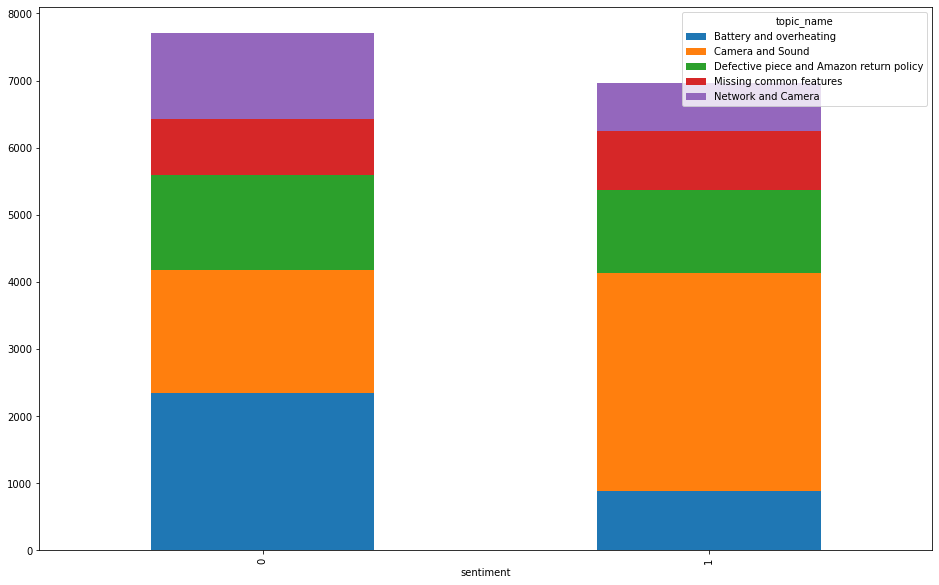

In [60]:
plt.rcParams['figure.figsize'] = (16,10)
df_dominant_topic_best.groupby(['sentiment','topic_name']).count()['Dominant_Topic'].unstack().plot(kind='bar',stacked = True)
plt.savefig("topic_sentiment_wise.png")

It can be seen that most of the people who rated negatively are talking about either battery and overheating problem or they are talking about camera quality and sound. But a large number of people who rated positively are also talking about camera and sound. It seems like, there is some subjectivity in judging the quality of camera and sound, but it remains the most talked about topic, regardless of whether people rated positively or negatively. There are people who faced problems regarding battery backup, charging and overheating, although the problem is not universal in all customers.

### What's the sentiment distribution for each topic?

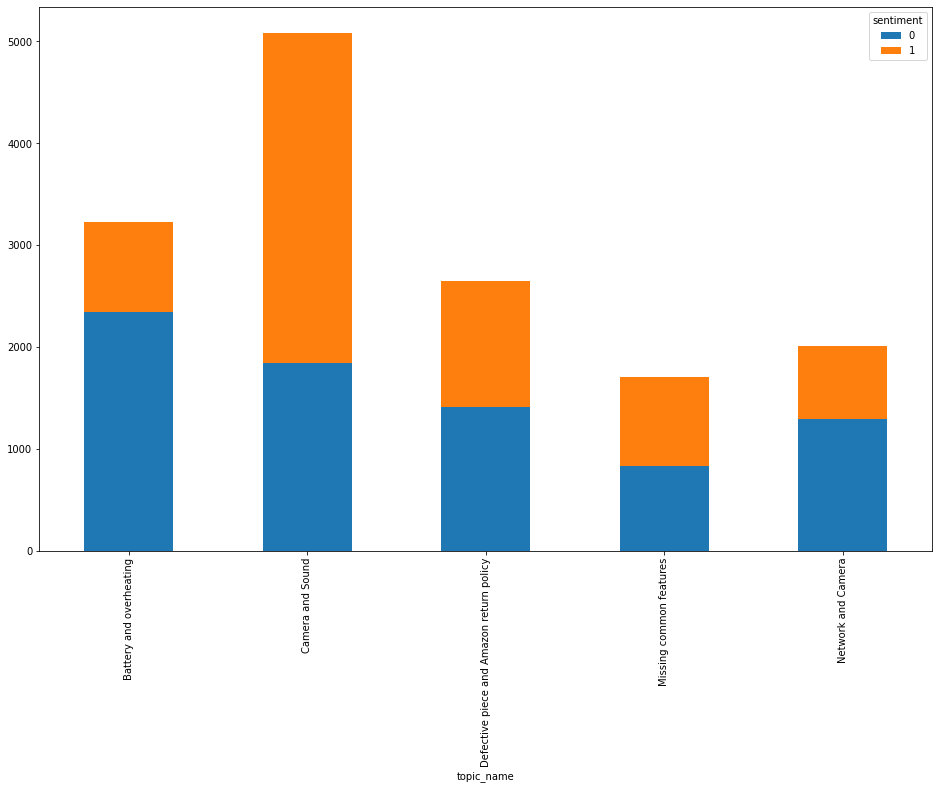

In [61]:
df_dominant_topic_best.groupby(['topic_name','sentiment']).count()['Dominant_Topic'].unstack().plot(kind='bar',stacked = True)
plt.savefig("each_topic_sentiment.png")

### Frequency distribution of different topics

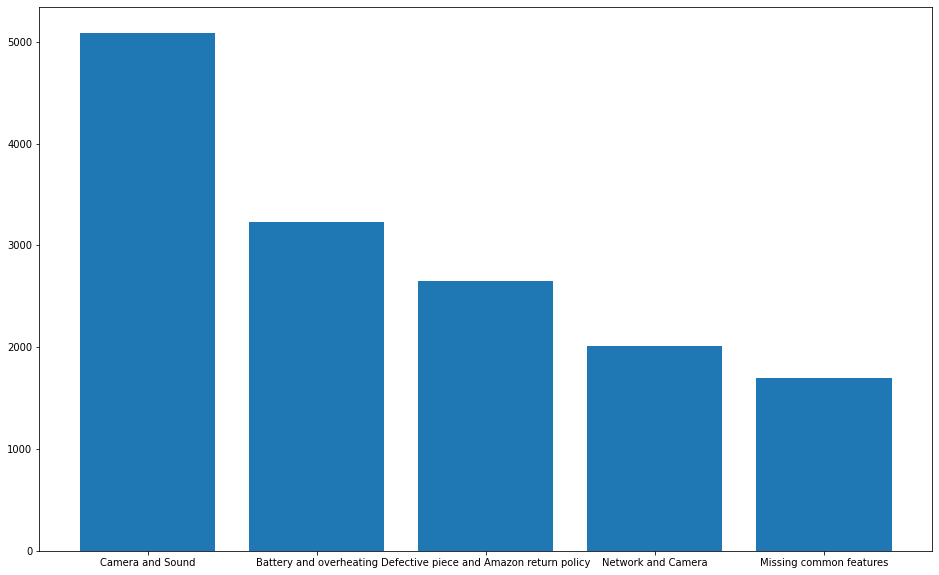

In [62]:
plt.bar(df_dominant_topic_best['topic_name'].value_counts().index,df_dominant_topic_best['Dominant_Topic'].value_counts().values)
plt.savefig("topic_freq_distr.png")